### Load existing model and see if the model approaches the Cramer Rao Lower Bound on single emitters


In [1]:
# Clone the SIMCODE source code
%cd /content
!git clone https://github.com/jcnossen/simcode.git
%cd /content/simcode/
!pip install -e .

%cd /content
# Google colab now requires either this, or restarting the runtime after doing a local package install
import site
site.main()


/content
Cloning into 'simcode'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 186 (delta 38), reused 55 (delta 21), pack-reused 102 (from 1)
Receiving objects: 100% (186/186), 51.58 MiB | 16.16 MiB/s, done.
Resolving deltas: 100% (51/51), done.
/content/simcode
Obtaining file:///content/simcode
  Preparing metadata (setup.py) ... done
  Running setup.py develop for smlmtorch
/content


In [2]:
simcode_model_zip = '/content/simcode/model/model_weights_sf_conv_g1.3_tio2_L64_2.zip'
simcode_model_path = '/content/simcode/model/sf_conv_g1.3_tio2_L64_2/'

!unzip -o {simcode_model_zip} -d /content/simcode/model/

Archive:  /content/simcode/model/model_weights_sf_conv_g1.3_tio2_L64_2.zip
  inflating: /content/simcode/model/sf_conv.ipynb  
   creating: /content/simcode/model/sf_conv_g1.3_tio2_L64_2/
  inflating: /content/simcode/model/sf_conv_g1.3_tio2_L64_2/checkpoint_1.pt  
  inflating: /content/simcode/model/sf_conv_g1.3_tio2_L64_2/config.yaml  
  inflating: /content/simcode/model/sf_conv_g1.3_tio2_L64_2/intensities_histogram.svg  


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch
from smlmtorch.util.config_dict import config_dict # dictionary indexable like object
from smlmtorch.nn.sf_model import SFLocalizationModel
from smlmtorch.nn.model_trainer import LocalizationModelTrainer

device = 'cuda:0'

config = config_dict.load(simcode_model_path + '/config.yaml')
trainer = LocalizationModelTrainer(config, SFLocalizationModel, device,
    save_dir = simcode_model_path, load_previous_model = True)  # note that save_dir is only used when trainer.train() is called


CheckpointManager initialized:  /content/simcode/model/sf_conv_g1.3_tio2_L64_2
Loaded checkpoint: /content/simcode/model/sf_conv_g1.3_tio2_L64_2/checkpoint_1.pt. Epoch: 172. Learning rate: 6.3e-07


### Plot spot intensity histogram used for training

k_on: 0.020 k_off: 0.17 num_spots: 145. avg_count: 15.4


  0%|          | 0/100 [00:00<?, ?it/s]

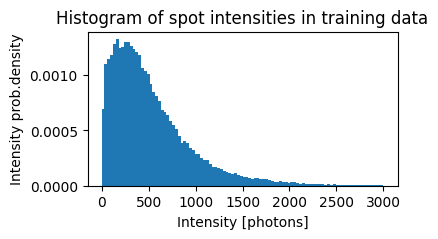

In [4]:
ds = trainer.data_generator.generate(100)
active = ds.spots_ds.spots[:,:,:,0]>0
intensities = ds.spots_ds.spots[:,:,:,1][active]

plt.figure(figsize=(4,2))
plt.hist(intensities, bins=100, range=[0,3000],density=True)
plt.title('Histogram of spot intensities in training data')
plt.ylabel('Intensity prob.density')
plt.xlabel('Intensity [photons]')
plt.savefig(trainer.save_dir+"/intensities_histogram.svg")

### Evaluate single emitter performance over a range of photon counts

  0%|          | 0/10 [00:00<?, ?it/s]

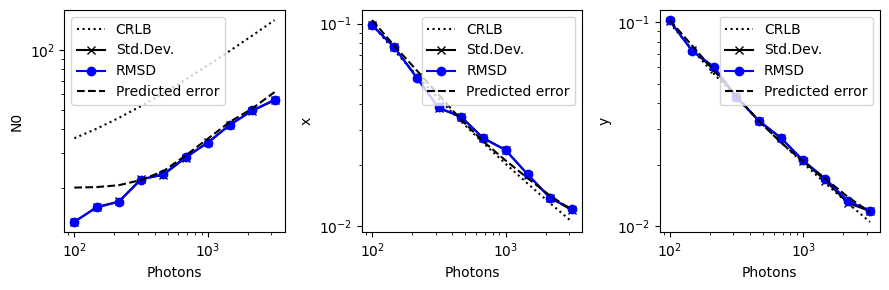

In [7]:
from smlmtorch.nn.benchmark.compare_crlb import CRLBPlotGenerator

photon_range = np.logspace(2, 3.5, 10)

crlb_plotter = CRLBPlotGenerator(trainer.model, 100,
    trainer.data_generator.psf,
    param_list=['N0', 'x', 'y'],
    psf_param_mapping = ['N', 'x', 'y'],
    sim_config=config.simulation, device=device)

crlb_plotter.plot_photon_range(photon_range, background=4,
    n_frames=6, log_step=0, log_writer=None);
